In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *
from ct_tracking_library.ct_fk_functions import *

#used for GUI
%matplotlib notebook

#find transform
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E
import transforms3d as t3d
import itertools

In [2]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    """
    This function is a helper function that helps the drop dwon list for DICOM file in folder:

    Args:
        series_to_load(list): list of the DICOM serial number in the folder.
        series_dictionary(dict): dict that holds the dicm files.

    """
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

In [3]:
def get_marker(selected_series,time,v = False, debug = False):
    """
    This function finds the marker from the user sleceted dicom file:

    Args:
        selected_series(string): the serial key for the slected DICOM.
        time(Time): time intial when the function is called.
        v(bool): to show visualization for the marker
        debug(bool): wheather or not the user want to see debug info.

    Returns:
        M_list[0](Marker): the moveing marker object finded
        M_list[1](Marker): the fixed marker object finded
        v_mesh(Open3d mesh): the mesh used for finding the marker in form of open3d

    """
    M_list = []
    data_directory = "./test_data/DICOM"
    file_reader = sitk.ImageFileReader()
    series_file_names = {}
    series_IDs = list(sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory))
    if series_IDs:
        for series in series_IDs:
            series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    for S in range(2):
        # pick marker
        if S == 0:
            target_marker_name = 'moving_marker_1_DoF'
            marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
            R = np.eye(3)
            crop_z = None
        else:
            target_marker_name = 'fixed_marker_1_DoF'
            marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
            R = np.eye(3)
            crop_z = None

        #convert scan to mesh for finding markers via thresholding
        scan_file = series_file_names[selected_series]
        convert_scan_to_mha(scan_file, crop_z = crop_z)
        convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

        #find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
        _, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=debug)
        if debug:
            print('marker centroid coordinates from design: {}'.format(marker))
            print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

        #display candidate fiducials
        if v:
            o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

        #find best transform and marker from candidate fiducials
        tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

        #get rid of column of ones to make 3xN
        permuted_centroids = permuted_centroids[:3,:].T

        #transform marker geometry coordinates using found transform to tracked image coordinates
        transformed_marker = (tracked_R @ marker.T + tracked_t).T
        error = permuted_centroids-transformed_marker
        
        #tracking error from final transform
        np.set_printoptions(2)
        print("Error (mm): {}".format(error))
        print("Error norm (mm): {}".format(np.linalg.norm(error)))
        if v:
            #create o3d visualizations
            marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
            marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
            marker_3d_base.append(create_coordinate_frame_visualization())
            marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
            marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))
            #visualize tracked markers on top of mesh used for tracking
            visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
            visualization_list1 = copy.deepcopy(visualization_list2)
            o3d.visualization.draw_geometries(visualization_list2)
        if S == 0:
            v_mesh= marker_mesh
        #append marker
        print("T find: ",tracked_t)
        M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=t2T(tracked_R, tracked_t),error=np.linalg.norm(error, axis=1)))
        
    return M_list[0],M_list[1],v_mesh

In [4]:
def calc_DLS_controller_step(J, e, alpha = 1.0, lambd = 0.01):
    '''
    calculates new position step using dls jacobian
    inputs: 
            J: [6xN] numpy array where N is the number of robot joints being controlled
            e: [6x1] numpy array for position and orientation errors stacked
            alpha: gain constant for position step
            lambd: damping constant for inverse
    return: 
        joint position setpoint delta
    '''
    J_inv = np.linalg.inv(J.T@J + lambd * np.eye(J.shape[1])) @ J.T
    return alpha * J_inv @ e

In [5]:
def close_loop(m1,m2,fk,r_error=None,p_error=None,Dof=True):
    if Dof:
        Tfk = SE3(m2.T).inv()*fk
        T2 = copy.deepcopy(Tfk)
        q_current = (SE3(m2.T).inv()*SE3(m1.T)).t[2]
        J = np.array([[0,0,1,0,0,0]]).T
        e = np.hstack((p_error.T[0],r_error))
        delta_q = calc_DLS_controller_step(J, e)
        print('Joint step calculated: {}'.format(delta_q))
        q_new = q_current + delta_q
        T2.t = [Tfk.t[0],Tfk.t[1],q_new]
        return T2,delta_q
    else:
        print("Crane bot")
        Tracked = SE3(m1)
        Target = SE3(fk)
        p_error = calc_p_error(Target.t,Tracked.t)
        r_error = t3d.euler.axangle2euler(calc_needle_ori_error(Target.R,Tracked.R))
        print("P: ")
        print(p_error)
        print("R: ")
        print(r_error)
        return p_error,r_error
    return True

## Feltch the DICOM file from server
### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient
### Selected Series on the top tabs
### On the left hand side input: DIMITRI07041995 as the Patient ID
### In the middle section select Newest Frist in the Order by Tab
### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit
### Download the 1st row by clicking the 3 dots symbol and downolad it
### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

Enter the number of loop: 2


<IPython.core.display.Javascript object>


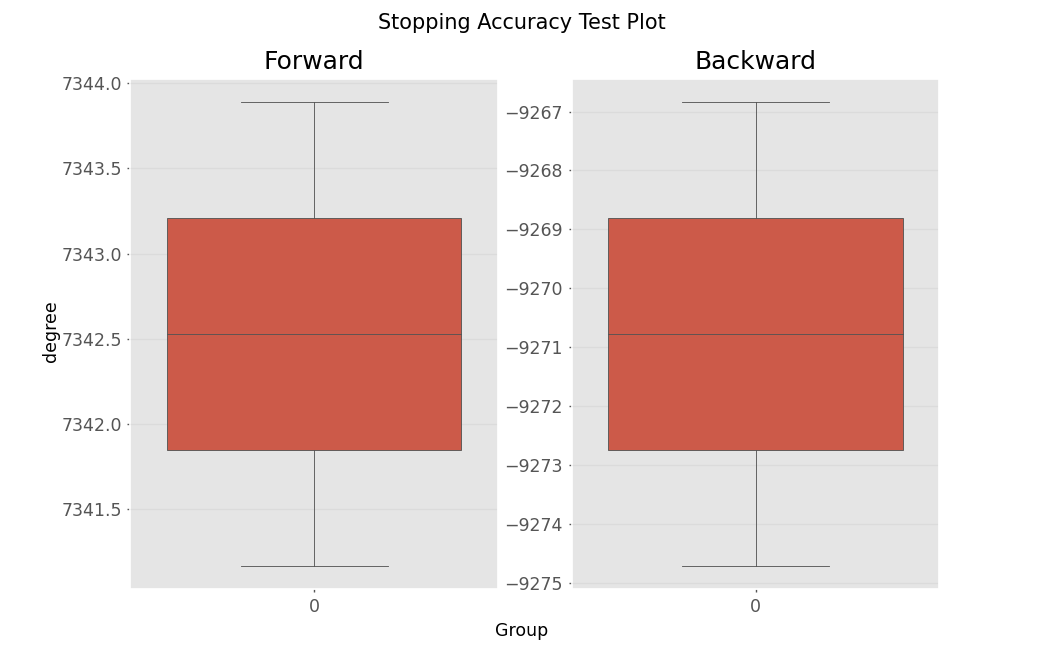

begin zeroing
begin zeroing
begin zeroing
begin zeroing
Begain Testing
Position(rev): -23.993881225585938
Position in Degree:  -1374.75
Position in mm:  -47.600975472131054


-23.993881225585938

In [6]:
c = moteus.Controller() # created moteus motor object
n = input('Enter the number of loop: ')
d1,d2 = await stopping_acc_test(c,int(n))
await read_p()

In [21]:
#SETUP DATA DIRECTORIES FOR THE TEST DAY
data = {}
reL = []
peL = []
s_num = 0
start = True
fk = None
#ratio = 0.5040628051757813 #converting mm to rev
ratio = 0.25040628051757813
ip = await motor_zero(c,stop_torque=.1,v=1) #ip is in rev

begin zeroing
state info:  1/{MODE(0x000): 0, POSITION(0x001): -12.976577758789062, VELOCITY(0x002): -0.04024256765842438, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 25.0, FAULT(0x00f): 0}
Position: -12.976577758789062
Torque: 0.0

motor is ready


In [ ]:
key_list = ['1.2.840.113619.2.416.6795503943617817801219389912763296544',
           '1.2.840.113619.2.416.6091776499222851246423953174468199664',
           '1.2.840.113619.2.416.100083941475652116358255918161510130375',
           '1.2.840.113619.2.416.61935088023485344866325542289366845877']

In [22]:
p_mm = await one_axis_farward(c,ip,user_desried=0) #P_mm in mm
zero_mm = p_mm

Begain Testing
Finish, the position is:  -50.820148536700984


## Loop start HERE

In [37]:
time = datetime.datetime.now()
time = time.strftime("%m/%d/%y %I:%M%p")
if start:
    robot = Robot(time=time,m=ratio,joint_postion=p_mm,set_point=0,d1=d1,d2=d2,zero=zero_mm)
    start = False
else:
    offset = (SE3(data['scan0'][1].T).inv()*SE3(data['scan0'][0].T)).t[2]
    ds = input("Enter the desried postion: ")
    m1t = SE3(marker1.T)
    Dersied = copy.deepcopy(m1t)
    Dersied.t[0] = m1t.t[0]+np.sign(m1t.t[0])*(int(ds))
    peval = abs(Dersied.t[0])-abs(SE3(marker1.T).t[0])
    fk,r_error,p_error = find_fk(marker1,marker2,robot,peval)
    reL.append(r_error)
    peL.append(p_error)
    q_new_T,d_q = close_loop(marker1,marker2,fk,r_error,p_error,Dof=True)
    #q_new = q_new_T.t[2]-offset
    q_new = int(robot.set_point)+d_q[0]
    if np.sign(d_q) > 0:
        p_mm = await one_axis_farward(c,ip,user_desried=q_new*ratio)
    else:
        p_mm = await one_axis_backward(c,ip,user_desried=q_new*ratio)
    robot = Robot(time=time,m=ratio,joint_postion=p_mm,set_point=ds,d1=d1,d2=d2,zero=zero_mm)

Enter the desried postion: 25
Postion Error norm(mm):  10.233094256405497
Rotional Error norm(Euler Angle):  [-6.44e-19  1.05e-02 -5.01e-03]
Joint step calculated: [10.13]
Begain Testing
Finish, the position is:  -33.68844950666369


In [33]:
data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)

    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.139204714109012789…

In [34]:
marker1,marker2,mesh = get_marker(selected_series,time) #selected_keys
if fk is not None:
    display_fk(fk,marker1,mesh)
    display_fk(SE3(marker2.T)*q_new_T,marker1,mesh)
    marker1.T2 = q_new_T
#save temp data   
append_value(data, "scan"+str(s_num), marker1)
append_value(data, "scan"+str(s_num), marker2)
append_value(data, "scan"+str(s_num), robot)
d_name = 'temp_data'+str(s_num)+'.pkl'
with open(d_name, 'wb') as f:
    pickle.dump(data, f)
s_num += 1

spacing:  [0.63 0.7  0.7 ]
 origin:  [-234.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=32
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 118.62it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
Everything looks good!
Error (mm): [[ 0.04  0.01  0.02]
 [-0.06 -0.02 -0.  ]
 [ 0.05 -0.03 -0.02]
 [-0.03  0.03  0.01]]
Error norm (mm): 0.10539993357750858
T find:  [[-37.74]
 [-12.08]
 [-55.18]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-234.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=32
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 110.60it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
Everything looks good!
Error (mm): [[-0.09 -0.19  0.01]
 [ 0.14 -0.06 -0.05]
 [-0.05  0.25 -0.01]
 [ 0.    0.    0.05]]
Error norm (mm): 0.3706373036164309
T find:  [[-15.17]
 [-31.76]
 [-14.39]]


In [38]:
final_pel = np.hstack((peL[0],peL[1]))
for x in peL[2:]:
    final_pel = np.hstack((final_pel,x))

In [43]:
await read_p()
with open('./test_data/data2.pkl', 'wb') as f:
    pickle.dump(data, f)
with open('./test_data/Postion2.pkl', 'wb') as f:
    pickle.dump(final_pel, f)
with open('./test_data/Rotaional2.pkl', 'wb') as f:
    pickle.dump(reL, f)

Begain Testing
Position(rev): -16.986587524414062
Position in Degree:  -973.26
Position in mm:  -33.6993472836988


<IPython.core.display.Javascript object>


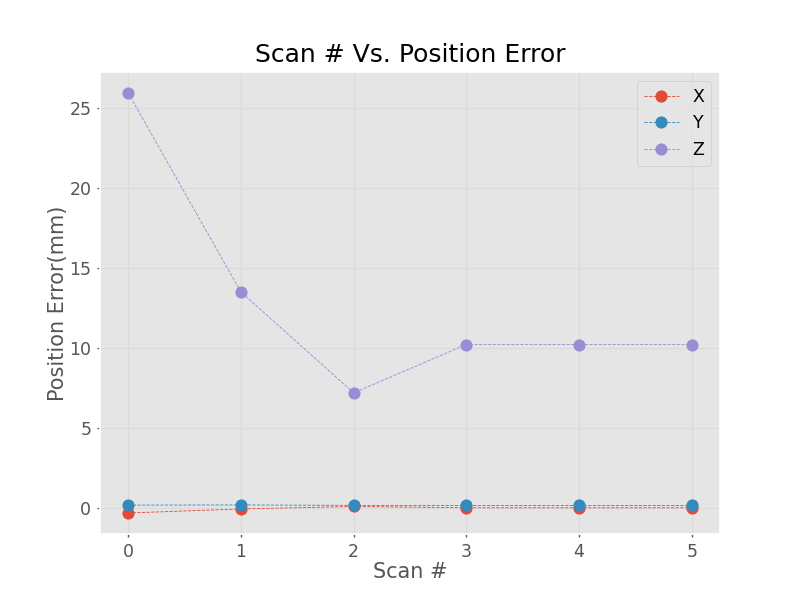

Text(0.5, 0, 'Scan #')

In [39]:
plt.plot(final_pel[0],linestyle='--', marker='o')
plt.plot(final_pel[1],linestyle='--', marker='o')
plt.plot(final_pel[2],linestyle='--', marker='o')
plt.legend(['X', 'Y','Z'])
plt.ylabel("Position Error(mm)")
plt.title("Scan # Vs. Position Error")
plt.xlabel("Scan #")

## ---------------------------------------End of the Code-----------------------------------

In [ ]:
await read_p()

In [ ]:
for x in range(len(u_list)):
    print("Moveing to ", u_list[x])
    if u_list[x] == 0:
        p_mm = await one_axis_farward(c,ip,user_desried=0) #P_mm in mm
        zero_mm = p_mm
    selected_series = key_list[x]
    #selected_keys = input('Enter DICOM key: ')
    #input('Press enter to start')
    time = datetime.datetime.now()
    time = time.strftime("%m/%d/%y %I:%M%p")
    marker1,marker2,mesh = get_marker(selected_series,time) #selected_keys
    robot = Robot(time=time,m=ratio,joint_postion=p_mm,set_point=u_list[x],d1=d1,d2=d2,zero=zero_mm)
    #5. calculate forward kinematics of joint position and error between and FK and tracking
    if x != len(u_list)-1:
        m1t = SE3(marker1.T)
        Dersied = copy.deepcopy(m1t)
        Dersied.t[0] = m1t.t[0]+np.sign(m1t.t[0])*(u_list[x+1])
        peval = abs(Dersied.t[0])-abs(SE3(marker1.T).t[0])
        fk,r_error,p_error = find_fk(marker1,marker2,robot,peval)
        q_new_T = close_loop(marker1,marker2,robot,fk,r_error,p_error,Dof=True)
        q_new = abs(SE3(q_new_T).t[2])
        p_mm = await one_axis_farward(c,ip,user_desried=q_new*ratio)
        robot.joint_postion = p_mm
    #6. display forward kinematics transforms + tracked marker transforms in open3D AND print errors with warnings
        display_fk(fk,marker1,mesh)
    #7. save everything to data directory w/ timestamp for this loop IF good for this loop to dictionary
    append_value(data, "scan"+str(s_num), marker1)
    append_value(data, "scan"+str(s_num), marker2)
    append_value(data, "scan"+str(s_num), robot)
    #8. save to temporary pickle file for this test every loop incase the software crashes
    d_name = 'temp_data'+str(s_num)+'.pkl'
    with open(d_name, 'wb') as f:
        pickle.dump(data, f)
    s_num += 1
#8. save to pickle file for final test data
with open('data4.pkl', 'wb') as f:
    pickle.dump(data, f)